In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

# Import relevant libraries
import numpy as np
from numpy import asarray
from PIL import Image
import os
import random
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.losses import BinaryCrossentropy
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN

%matplotlib inline

# Data Parsing
## All the user has to do is to insert the folder with the faces images and the folder without faces.
### Then, we automatically divide the data into training (about 75%) and testing (about 25%), and format the images so they're a 256x256 image (The user can change the value for example: 512x512 or 1024x1024) but the model will take more time to train.

In [3]:
# Source
# https://note.nkmk.me/en/python-pillow-square-circle-thumbnail/
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

def square_img(directory, size=256):
    training_dir = directory + '_train'
    testing_dir = directory + '_test'
    
    # Clean both test and training folders, and recreate them
    if os.path.isdir(training_dir):
        for f in os.listdir(training_dir):
            os.remove(training_dir + '/' + f)
        os.rmdir(training_dir)
    if os.path.isdir(testing_dir):
        for f in os.listdir(testing_dir):
            os.remove(testing_dir + '/' + f)
        os.rmdir(testing_dir)
    os.mkdir(training_dir)
    os.mkdir(testing_dir)
    
    # 25% of images for test and 75% for training
    path, dirs, files = next(os.walk(directory))
    count_examples = 0
    test_examples = int(len(files) * 0.25)
    print("Getting test data")
    
    # Save all in training dir
    for filename in os.listdir(directory):
        f = directory + '/' + filename
        im = Image.open(f)
        new_image = expand2square(im, (0, 0, 0)).resize((size, size), Image.LANCZOS)
        newfilename = training_dir + '/' + filename
        new_image.save(newfilename)
    # Pass from training folder to testing
    while True:
        for filename in os.listdir(training_dir):
            f = training_dir + '/' + filename
            im = Image.open(f)
            # Add black bars to the side of the images
            new_image = expand2square(im, (0, 0, 0)).resize((size, size), Image.LANCZOS)
            # Randomly pass some images to test folder
            test_p = random.randint(0, 12)
            if test_p == 6:
                newfilename = testing_dir + '/' + filename
                new_image.save(newfilename)
                os.remove(training_dir + '/' + filename)
                count_examples += 1
            if count_examples == test_examples:
                break
        if count_examples == test_examples:
                break
            
    return training_dir, testing_dir

In [4]:
# Insert the name of the directory
faces_directory = 'faces'
no_faces_directory = 'no_faces'

# Square the image and turn it into a 256x256 jpeg (optional: pass the size as second argument ex: 512)
faces_dir_train, faces_dir_test = square_img(faces_directory)
no_faces_dir_train, no_faces_dir_test = square_img(no_faces_directory)

Getting test data
Getting test data


# Training Images
### Now we parse the training images and label them as 0 (no face) or 1 (face)


In [5]:
ls = []
label_ls = []
i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk(faces_dir_train))
print("Total images: ", len(files))
if int(len(files) / 1000) > 0:
    interval = int(len(files) / 1000)
for filename in os.listdir(faces_dir_train):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(faces_dir_train + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(1)
print("Number of images used to train the model: ", j)

i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk(no_faces_dir_train))
print("Total images: ", len(files))
if int(len(files) / 1000) > 0:
    interval = int(len(files) / 1000)
for filename in os.listdir(no_faces_dir_train):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(no_faces_dir_train + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(0)
print("Number of images used to train the model: ", j)


imgs_train = np.array(ls, dtype='uint8')
label_train = np.array([label_ls])

Total images:  726
Number of images used to train the model:  726
Total images:  726
Number of images used to train the model:  726


# Testing images
### Now we parse the testing images and label them as 0 (no face) or 1 (face)

In [6]:
ls = []
label_ls = []
i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk(faces_dir_test))
print("Total images: ", len(files))
if int(len(files) / 1000) > 0:
    interval = int(len(files) / 1000)
for filename in os.listdir(faces_dir_test):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(faces_dir_test + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(1)
print("Number of images used to train the model: ", j)

i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk(no_faces_dir_test))
print("Total images: ", len(files))
if int(len(files) / 1000) > 0:
    interval = int(len(files) / 1000)
for filename in os.listdir(no_faces_dir_test):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(no_faces_dir_test + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(0)
print("Number of images used to train the model: ", j)


imgs_test = np.array(ls, dtype='uint8')
label_test = np.array([label_ls])

Total images:  241
Number of images used to train the model:  241
Total images:  241
Number of images used to train the model:  241


In [7]:
# Normalize image vectors
imgs_train_norm = imgs_train / 255.
imgs_test_norm = imgs_test / 255.

# Reshape
label_train_T = label_train.T
label_test_T = label_test.T

print ("Number of training examples = " + str(imgs_train_norm.shape[0]))
print ("Number of testing examples = " + str(imgs_test_norm.shape[0]))
print ("Images train shape: " + str(imgs_train_norm.shape))
print ("Labels train shape: " + str(label_train_T.shape))
print ("Images test shape: " + str(imgs_test_norm.shape))
print ("Labels test shape: " + str(label_test_T.shape))

Number of training examples = 1452
Number of testing examples = 482
Images train shape: (1452, 256, 256, 3)
Labels train shape: (1452, 1)
Images test shape: (482, 256, 256, 3)
Labels test shape: (482, 1)


In [8]:
def FaceDetectionModel(input_shape):
    """
    Implementation of the FaceDetectionModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Use the suggested model in the text above to get started, and run through the whole
    # exercise once. Then come back and add more BLOCKS. 
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)
    
    # BLOCK 1: CONV -> BN -> RELU -> MAXP
    num_filters = 32
    kernel_size = (7, 7)
    stride = (1, 1)
    X = Conv2D(num_filters, kernel_size, strides = stride, name = 'conv0')(X)

    # BLOCK 2: CONV -> BN -> RELU -> MAXP
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
        
    # BLOCK 3: CONV -> BN -> RELU -> MAXP
    X = Activation('relu')(X)
    
    # BLOCK 4: CONV -> BN -> RELU -> MAXP
    max_pool_size = (2, 2)
    X = MaxPooling2D(max_pool_size, name='max_pool')(X)
       
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model.
    model = Model(inputs = X_input, outputs = X, name='FaceDetectionModel')
    
    return model

In [9]:
facedetectionmodel = FaceDetectionModel(imgs_train_norm.shape[1:])

In [10]:
facedetectionmodel.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=["accuracy"])

In [11]:
facedetectionmodel.summary()

Model: "FaceDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 262, 262, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 256, 256, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 256, 256, 32)      128       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pool (MaxPooling2D)     (None, 128, 128, 32)      0         
                                                

In [12]:
history = facedetectionmodel.fit(
    imgs_train_norm, label_train_T,
    batch_size = 64,
    epochs = 10,
    validation_data = (imgs_test_norm, label_test_T)
)

Epoch 1/10
23/23 [==============================] - 234s 10s/step - loss: 4.6689 - accuracy: 0.8567 - val_loss: 1.9688 - val_accuracy: 0.7469
Epoch 2/10
23/23 [==============================] - 222s 10s/step - loss: 0.4066 - accuracy: 0.9787 - val_loss: 0.9117 - val_accuracy: 0.8589
Epoch 3/10
23/23 [==============================] - 241s 10s/step - loss: 0.1626 - accuracy: 0.9910 - val_loss: 0.8906 - val_accuracy: 0.8942
Epoch 4/10
23/23 [==============================] - 219s 9s/step - loss: 0.0242 - accuracy: 0.9966 - val_loss: 1.2614 - val_accuracy: 0.8755
Epoch 5/10
23/23 [==============================] - 217s 9s/step - loss: 0.1610 - accuracy: 0.9897 - val_loss: 1.2089 - val_accuracy: 0.8838
Epoch 6/10
23/23 [==============================] - 190s 8s/step - loss: 0.0729 - accuracy: 0.9931 - val_loss: 1.4026 - val_accuracy: 0.8880
Epoch 7/10
23/23 [==============================] - 190s 8s/step - loss: 0.0734 - accuracy: 0.9924 - val_loss: 1.3996 - val_accuracy: 0.9066
Epoch 8/10

In [13]:
preds = facedetectionmodel.evaluate(x = imgs_test_norm, y = label_test_T)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

16/16 [==============================] - 8s 507ms/step - loss: 0.7624 - accuracy: 0.9523
Loss = 0.7624258995056152
Test Accuracy = 0.9522821307182312


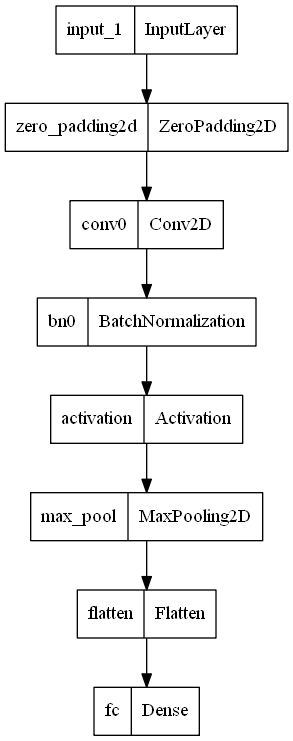

In [14]:
# plots the model in a nice layout and save it as ".png"
plot_model(facedetectionmodel, to_file='FaceDetectionModel.png')

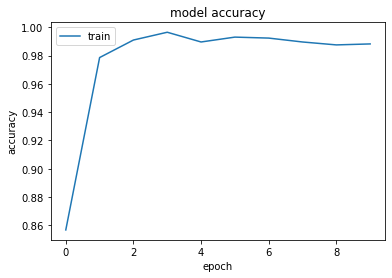

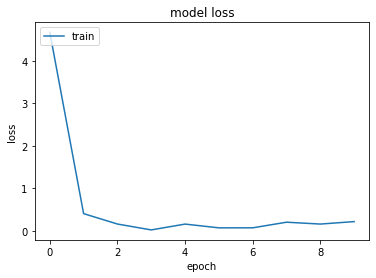

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [16]:
def draw_image_with_boxes(filename, result_list):
    data = pyplot.imread(filename)
    pyplot.imshow(data)
    ax = pyplot.gca()
    for result in result_list:
        x, y, width, height = result['box']
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        ax.add_patch(rect)
    pyplot.savefig("result")
    pyplot.show()

The image has no faces


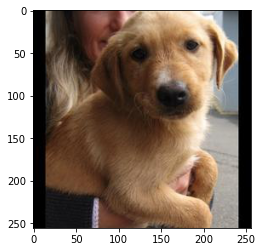

In [17]:
# Test our own images
test_directory = 'test_imgs'
img_path = test_directory + '/0_2717.jpg'
img = image.load_img(img_path, target_size=(256, 256))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


if facedetectionmodel.predict(x)[0][0] == 1:
    face = 0
    print('The image has a face')
    filename = img_path
    pixels = pyplot.imread(filename)
    detector = MTCNN()
    faces = detector.detect_faces(pixels)
    draw_image_with_boxes(filename, faces)

elif facedetectionmodel.predict(x)[0][0] == 0:
    imshow(img)
    face = 1
    print('The image has no faces')

# Calculate accuracy, precision, recall and F1 score

In [19]:
# Add imgs to list
no_faces_ls = []
faces_ls = []
# Total number of imgs with faces and no faces
tot_faces = 0
tot_no_faces = 0

for filename in os.listdir(test_directory):
    if filename[0] == '0':
        no_faces_ls.append(filename)
        tot_no_faces += 1
    else:
        faces_ls.append(filename)
        tot_faces += 1

# number of true positives, true negatives, false positives and false negatives
num_tp = 0
num_tn = 0
num_fp = 0
num_fn = 0
        
# Testing on all no_faces
print('-------------------')
print('Should be 0 (no faces)')
for img_name in no_faces_ls:
    img_path = test_directory + '/' + img_name
    img = image.load_img(img_path, target_size=(256, 256))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    if facedetectionmodel.predict(x)[0][0] == 0:
        num_tn += 1
    else:
        num_fp += 1
    print(img_name + ': ' + str(facedetectionmodel.predict(x)[0][0]))
    
# Testing on all faces
print('-------------------')
print('Should be 1 (faces)')
for img_name in faces_ls:
    img_path = test_directory + '/' + img_name
    img = image.load_img(img_path, target_size=(256, 256))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    if facedetectionmodel.predict(x)[0][0] == 0:
        num_fn += 1
    else:
        num_tp += 1
    print(img_name + ': ' + str(facedetectionmodel.predict(x)[0][0]))
    
accuracy = ((num_tp + num_tn) / (num_tp + num_tn + num_fp + num_fn))
precision = num_tp / (num_tp + num_fp)
recall = num_tp / (num_tp + num_fn)
f1_score = 2 * (recall * precision) / (recall + precision)
print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1 Score: ' + str(f1_score))

-------------------
Should be 0 (no faces)
0_125.jpg: 0.0
0_1407.jpg: 0.0
0_1681.jpg: 0.0
0_1874.jpg: 0.0
0_2111.jpg: 0.0
0_2332.jpg: 0.0
0_2448.jpg: 0.0
0_2717.jpg: 0.0
0_2754.jpg: 0.0
0_3454.jpg: 0.0
0_3742.jpg: 0.0
0_3822.jpg: 0.0
0_4045.jpg: 0.0
0_4112.jpg: 0.0
0_4319.jpg: 0.0
0_4943.jpg: 0.0
0_5005.jpg: 0.0
0_5434.jpg: 0.0
0_5642.jpg: 0.0
0_5750.jpg: 0.0
0_5804.jpg: 0.0
0_860.jpg: 0.0
-------------------
Should be 1 (faces)
person_0053.jpg: 1.0
person_0111.jpg: 1.0
person_0114.jpg: 1.0
person_0142.jpg: 1.0
person_0179.jpg: 0.0
person_0322.jpg: 0.0
person_0487.jpg: 1.0
person_0493.jpg: 1.0
person_0511.jpg: 0.0
person_0562.jpg: 1.0
person_0573.jpg: 0.0
person_0686.jpg: 0.0
person_0690.jpg: 1.0
person_0723.jpg: 1.0
person_0744.jpg: 1.0
person_0792.jpg: 0.0
person_0864.jpg: 0.0
person_0866.jpg: 0.0
person_0911.jpg: 0.0
person_1000.jpg: 0.0
Accuracy: 0.7619047619047619
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
